# Two-car platooning on the track (leader–follower) Project

# Leader Code Formate

# **LMPC for Autonomous Racing**

These notes were developed by Ugo Rosolia, Charlott Vallon and Francesco Borrelli at UC Berkeley, and Luigi Glielmo at Università di Napoli Federico II. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

You may not reproduce, distribute or display (post/upload) lecture notes or recordings or course materials in any way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

In [55]:
# install required dependencies
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import linalg as la
from numpy import hstack, inf, ones
from cvxopt import spmatrix, matrix, solvers
from cvxopt.solvers import qp
from cvxopt import spmatrix, matrix, solvers
from scipy import linalg
from scipy import sparse
from scipy.sparse import vstack
import datetime
from osqp import OSQP
from dataclasses import dataclass, field

✓ All libraries imported successfully


#Map

We will use a curvilinear parameterization of different race track shapes.  Given a specified track shape parameter set, we will be able to coordinate between the curvilinear reference frame to the inertial reference frame (X,Y), and vice versa.

Several maps have been hard-coded for you, but feel free to create your own!

In [67]:
# ======================================================================
# MAP CLASS
# ======================================================================
# This class defines a race track using a curvilinear coordinate system.
# It provides transformations between:
#   - curvilinear coordinates (s, ey)
#   - inertial/global coordinates (X, Y)
#
# The track is defined as a sequence of straight and curved segments.
# Each segment is described by its length and curvature.
# ======================================================================

class Map():
    """map object
    Attributes:
        getGlobalPosition: convert position from (s, ey) to (X,Y)
    """

    def __init__(self, halfWidth):
        """Initialization
        halfWidth: track halfWidth
        Modify the vector spec to change the geometry of the track
        """

        # -----------------------------
        # Track geometric parameters
        # -----------------------------
        # Track half width and slack (tolerance used when checking if a point is on the track)
        self.halfWidth = 0.4
        self.slack = 0.45
        self.DesiredGap = 1

        # -----------------------------
        # Track specification
        # -----------------------------
        # Each row of spec = [segment length, curvature radius]
        # curvature = 0     -> straight segment
        # curvature ≠ 0     -> circular arc
        lengthCurve = 4.5

        # L-shaped track
        spec = np.array([[1.0, 0],
                         [lengthCurve, lengthCurve / np.pi],
                         # Note s = 1 * np.pi / 2 and r = -1 ---> Angle spanned = np.pi / 2
                         [lengthCurve / 2, -lengthCurve / np.pi],
                         [lengthCurve, lengthCurve / np.pi],
                         [lengthCurve / np.pi * 2, 0],
                         [lengthCurve / 2, lengthCurve / np.pi]])

        # ------------------------------------------------------------------
        # ALTERNATIVE TRACK SHAPES (COMMENTED OUT)
        # ------------------------------------------------------------------
        # spec = np.array([[1.0, 0],
        #                  [4.5, -4.5 / np.pi],
        #                  [2.0, 0],
        #                  [4.5, -4.5 / np.pi],
        #                  [1.0, 0]])

        # Goggle-shaped track
        # self.slack = 0.15
        # self.halfWidth = halfWidth
        # spec = np.array([...])

        # ------------------------------------------------------------------
        # POINT AND TANGENT MATRIX
        # ------------------------------------------------------------------
        # Each row contains:
        # [x, y, psi, cumulative s, segment length, signed curvature]
        # ------------------------------------------------------------------
        PointAndTangent = np.zeros((spec.shape[0] + 1, 6))

        for i in range(0, spec.shape[0]):

            # ==============================================================
            # STRAIGHT SEGMENT
            # ==============================================================
            if spec[i, 1] == 0.0:
                l = spec[i, 0]  # segment length

                if i == 0:
                    ang = 0
                    x = l * np.cos(ang)
                    y = l * np.sin(ang)
                else:
                    ang = PointAndTangent[i - 1, 2]
                    x = PointAndTangent[i - 1, 0] + l * np.cos(ang)
                    y = PointAndTangent[i - 1, 1] + l * np.sin(ang)

                psi = ang  # tangent angle at end of segment

                if i == 0:
                    NewLine = np.array([x, y, psi, PointAndTangent[i, 3], l, 0])
                else:
                    NewLine = np.array([x, y, psi,
                                        PointAndTangent[i - 1, 3] + PointAndTangent[i - 1, 4],
                                        l, 0])

                PointAndTangent[i, :] = NewLine

            # ==============================================================
            # CURVED SEGMENT
            # ==============================================================
            else:
                l = spec[i, 0]
                r = spec[i, 1]

                direction = 1 if r >= 0 else -1

                if i == 0:
                    ang = 0
                    CenterX = np.abs(r) * np.cos(ang + direction * np.pi / 2)
                    CenterY = np.abs(r) * np.sin(ang + direction * np.pi / 2)
                else:
                    ang = PointAndTangent[i - 1, 2]
                    CenterX = PointAndTangent[i - 1, 0] + np.abs(r) * np.cos(ang + direction * np.pi / 2)
                    CenterY = PointAndTangent[i - 1, 1] + np.abs(r) * np.sin(ang + direction * np.pi / 2)

                spanAng = l / np.abs(r)
                psi = wrap(ang + spanAng * np.sign(r))

                angleNormal = wrap((direction * np.pi / 2 + ang))
                angle = -(np.pi - np.abs(angleNormal)) * (sign(angleNormal))

                x = CenterX + np.abs(r) * np.cos(angle + direction * spanAng)
                y = CenterY + np.abs(r) * np.sin(angle + direction * spanAng)

                if i == 0:
                    NewLine = np.array([x, y, psi, PointAndTangent[i, 3], l, 1 / r])
                else:
                    NewLine = np.array([x, y, psi,
                                        PointAndTangent[i - 1, 3] + PointAndTangent[i - 1, 4],
                                        l, 1 / r])

                PointAndTangent[i, :] = NewLine

        # ------------------------------------------------------------------
        # CLOSE THE TRACK (RETURN TO ORIGIN)
        # ------------------------------------------------------------------
        xs = PointAndTangent[-2, 0]
        ys = PointAndTangent[-2, 1]

        xf = 0
        yf = 0
        psif = 0

        l = np.sqrt((xf - xs) ** 2 + (yf - ys) ** 2)

        NewLine = np.array([xf, yf, psif,
                            PointAndTangent[-2, 3] + PointAndTangent[-2, 4],
                            l, 0])

        PointAndTangent[-1, :] = NewLine

        self.PointAndTangent = PointAndTangent
        self.TrackLength = PointAndTangent[-1, 3] + PointAndTangent[-1, 4]
    # ==================================================================
    # CURVILINEAR → GLOBAL COORDINATES
    # ==================================================================
    def getGlobalPosition(self, s, ey):
        """Convert (s, ey) to (X, Y)"""

        while (s > self.TrackLength):
            s = s - self.TrackLength

        PointAndTangent = self.PointAndTangent

        index = np.all([[s >= PointAndTangent[:, 3]],
                        [s < PointAndTangent[:, 3] + PointAndTangent[:, 4]]],
                       axis=0)

        i = int(np.where(np.squeeze(index))[0])

        # ------------------------------
        # STRAIGHT SEGMENT
        # ------------------------------
        if PointAndTangent[i, 5] == 0.0:
            xf = PointAndTangent[i, 0]
            yf = PointAndTangent[i, 1]
            xs = PointAndTangent[i - 1, 0]
            ys = PointAndTangent[i - 1, 1]
            psi = PointAndTangent[i, 2]

            deltaL = PointAndTangent[i, 4]
            reltaL = s - PointAndTangent[i, 3]

            x = (1 - reltaL / deltaL) * xs + reltaL / deltaL * xf + ey * np.cos(psi + np.pi / 2)
            y = (1 - reltaL / deltaL) * ys + reltaL / deltaL * yf + ey * np.sin(psi + np.pi / 2)

        # ------------------------------
        # CURVED SEGMENT
        # ------------------------------
        else:
            r = 1 / PointAndTangent[i, 5]
            ang = PointAndTangent[i - 1, 2]
            direction = 1 if r >= 0 else -1

            CenterX = PointAndTangent[i - 1, 0] + np.abs(r) * np.cos(ang + direction * np.pi / 2)
            CenterY = PointAndTangent[i - 1, 1] + np.abs(r) * np.sin(ang + direction * np.pi / 2)

            spanAng = (s - PointAndTangent[i, 3]) / np.abs(r)

            angleNormal = wrap((direction * np.pi / 2 + ang))
            angle = -(np.pi - np.abs(angleNormal)) * (sign(angleNormal))

            x = CenterX + (np.abs(r) - direction * ey) * np.cos(angle + direction * spanAng)
            y = CenterY + (np.abs(r) - direction * ey) * np.sin(angle + direction * spanAng)

        return x, y

    # ==================================================================
    # GLOBAL → CURVILINEAR COORDINATES
    # ==================================================================
    def getLocalPosition(self, x, y, psi):
        """Convert (X,Y,psi) to (s, ey, epsi)"""

        PointAndTangent = self.PointAndTangent
        CompletedFlag = 0

        for i in range(0, PointAndTangent.shape[0]):

            if CompletedFlag == 1:
                break

            # ==============================================================
            # STRAIGHT SEGMENT
            # ==============================================================
            if PointAndTangent[i, 5] == 0.0:
                xf = PointAndTangent[i, 0]
                yf = PointAndTangent[i, 1]
                xs = PointAndTangent[i - 1, 0]
                ys = PointAndTangent[i - 1, 1]

                psi_unwrap = np.unwrap([PointAndTangent[i - 1, 2], psi])[1]
                epsi = psi_unwrap - PointAndTangent[i - 1, 2]

                if la.norm(np.array([xs, ys]) - np.array([x, y])) == 0:
                    s = PointAndTangent[i, 3]
                    ey = 0
                    CompletedFlag = 1

                elif la.norm(np.array([xf, yf]) - np.array([x, y])) == 0:
                    s = PointAndTangent[i, 3] + PointAndTangent[i, 4]
                    ey = 0
                    CompletedFlag = 1

                else:
                    if (np.abs(computeAngle([x, y], [xs, ys], [xf, yf])) <= np.pi / 2 and
                        np.abs(computeAngle([x, y], [xf, yf], [xs, ys])) <= np.pi / 2):

                        v1 = np.array([x, y]) - np.array([xs, ys])
                        angle = computeAngle([xf, yf], [xs, ys], [x, y])

                        s_local = la.norm(v1) * np.cos(angle)
                        s = s_local + PointAndTangent[i, 3]
                        ey = la.norm(v1) * np.sin(angle)

                        if np.abs(ey) <= self.halfWidth + self.slack:
                            CompletedFlag = 1

            # ==============================================================
            # CURVED SEGMENT
            # ==============================================================
            else:
                xf = PointAndTangent[i, 0]
                yf = PointAndTangent[i, 1]
                xs = PointAndTangent[i - 1, 0]
                ys = PointAndTangent[i - 1, 1]

                r = 1 / PointAndTangent[i, 5]
                direction = 1 if r >= 0 else -1
                ang = PointAndTangent[i - 1, 2]

                CenterX = xs + np.abs(r) * np.cos(ang + direction * np.pi / 2)
                CenterY = ys + np.abs(r) * np.sin(ang + direction * np.pi / 2)

                if la.norm(np.array([xs, ys]) - np.array([x, y])) == 0:
                    ey = 0
                    psi_unwrap = np.unwrap([ang, psi])[1]
                    epsi = psi_unwrap - ang
                    s = PointAndTangent[i, 3]
                    CompletedFlag = 1

                elif la.norm(np.array([xf, yf]) - np.array([x, y])) == 0:
                    s = PointAndTangent[i, 3] + PointAndTangent[i, 4]
                    ey = 0
                    psi_unwrap = np.unwrap([PointAndTangent[i, 2], psi])[1]
                    epsi = psi_unwrap - PointAndTangent[i, 2]
                    CompletedFlag = 1

                else:
                    arc1 = PointAndTangent[i, 4] * PointAndTangent[i, 5]
                    arc2 = computeAngle([xs, ys], [CenterX, CenterY], [x, y])

                    if np.sign(arc1) == np.sign(arc2) and np.abs(arc1) >= np.abs(arc2):
                        v = np.array([x, y]) - np.array([CenterX, CenterY])
                        s_local = np.abs(arc2) * np.abs(r)
                        s = s_local + PointAndTangent[i, 3]
                        ey = -np.sign(direction) * (la.norm(v) - np.abs(r))

                        psi_unwrap = np.unwrap([ang + arc2, psi])[1]
                        epsi = psi_unwrap - (ang + arc2)

                        if np.abs(ey) <= self.halfWidth + self.slack:
                            CompletedFlag = 1

        if CompletedFlag == 0:
            s = 10000
            ey = 10000
            epsi = 10000
            print("Error!! POINT OUT OF THE TRACK!!!! <==================")

        return s, ey, epsi, CompletedFlag

    # ==================================================================
    # CURVATURE AT s
    # ==================================================================
    def curvature(self, s):
        TrackLength = self.PointAndTangent[-1, 3] + self.PointAndTangent[-1, 4]

        while (s > TrackLength):
            s = s - TrackLength

        index = np.all([[s >= self.PointAndTangent[:, 3]],
                        [s < self.PointAndTangent[:, 3] + self.PointAndTangent[:, 4]]],
                       axis=0)

        i = int(np.where(np.squeeze(index))[0])
        return self.PointAndTangent[i, 5]

    # ==================================================================
    # GLOBAL HEADING ANGLE
    # ==================================================================
    def getAngle(self, s, epsi):
        TrackLength = self.PointAndTangent[-1, 3] + self.PointAndTangent[-1, 4]

        while (s > TrackLength):
            s = s - TrackLength

        index = np.all([[s >= self.PointAndTangent[:, 3]],
                        [s < self.PointAndTangent[:, 3] + self.PointAndTangent[:, 4]]],
                       axis=0)

        i = int(np.where(np.squeeze(index))[0])

        ang = self.PointAndTangent[i - 1, 2] if i > 0 else 0

        if self.PointAndTangent[i, 5] == 0:
            angle_at_s = ang + epsi
        else:
            r = 1 / self.PointAndTangent[i, 5]
            relative_s = s - self.PointAndTangent[i, 3]
            spanAng = relative_s / np.abs(r)
            psi = wrap(ang + spanAng * np.sign(r))
            angle_at_s = psi + epsi

        return angle_at_s


# ======================================================================
# UTILITY FUNCTIONS
# ======================================================================

def computeAngle(point1, origin, point2):
    """Signed angle between vectors (origin → point1) and (origin → point2)"""
    v1 = np.array(point1) - np.array(origin)
    v2 = np.array(point2) - np.array(origin)
    dot = v1[0] * v2[0] + v1[1] * v2[1]
    det = v1[0] * v2[1] - v1[1] * v2[0]
    return np.arctan2(det, dot)


def wrap(angle):
    """Wrap angle to [-pi, pi]"""
    if angle < -np.pi:
        return 2 * np.pi + angle
    elif angle > np.pi:
        return angle - 2 * np.pi
    return angle


def sign(a):
    """Sign function"""
    return 1 if a >= 0 else -1


#Simulator

The simulator defines the "real" system; here, we use a dynamic bicycle model defined in the curvilinear abscessa frame. Note that our LMPC controller later will estimate a linearized version of this model using data, so $f$ and $f_{test}$ will be different!

In [68]:
# ======================================================================
# SIMULATOR CLASS
# ======================================================================
# This class simulates the "real" system used by the LMPC.
# It propagates the vehicle dynamics forward in time using:
#   - a nonlinear dynamic bicycle model
#   - a fine internal integration step (deltaT)
#   - both global (X,Y,psi) and curvilinear (s,ey,epsi) coordinates
#
# IMPORTANT:
# The controller (LMPC / MPC) does NOT use this exact model.
# This model represents the true plant, while the controller
# uses an identified / linearized approximation.
# ======================================================================

class SIMULATOR(object):
	""" Finite Time Optimal Control Problem (FTOCP)
	Methods:
		- solve: solves the FTOCP given the initial condition x0, terminal contraints (optinal) and terminal cost (optional)
		- model: given x_t and u_t computes x_{t+1} = Ax_t + Bu_t
	"""

	def __init__(self, system, dt = 0.1,  map = []):
		# --------------------------------------------------------------
		# Store simulator configuration
		# --------------------------------------------------------------
		# system : string defining which dynamic model to use
		# dt     : sampling time used by the controller
		# map    : Map object (used to compute curvature and coordinates)
		self.system = system
		self.dt = dt
		self.map = map

	def sim(self, x, u):
		# --------------------------------------------------------------
		# Wrapper function for simulation
		# --------------------------------------------------------------
		# x : [x_curvilinear, x_global]
		# u : control input [steering, acceleration]
		# --------------------------------------------------------------
		if self.system == "dyn_bicycle_model":
			x, x_glob = self.dyn_bicycle_model(x, u)
			x_next = [x, x_glob]
		return x_next

	# ==================================================================
	# COMPUTE ROAD EDGES (FOR VISUALIZATION)
	# ==================================================================
	def computeRoadEdges(self, s_start, s_end, circleRadius, roadHalfWidth, signEdge = 1, disc = 1):
		# Computes left or right road boundary for curved tracks
		# Used mainly for plotting and visualization
		edges = []
		for k in np.arange(s_start, s_end+disc, disc):
			angle  = k / circleRadius
			radius = circleRadius + signEdge * roadHalfWidth
			edges.append([radius * np.sin(angle),
						  circleRadius - radius * np.cos(angle)])
		return np.array(edges)

	# ==================================================================
	# CURVILINEAR → GLOBAL COORDINATES (SIMPLE CIRCULAR CASE)
	# ==================================================================
	def from_curvilinear_to_xy(self, xcl_feasible):
		# Converts a curvilinear trajectory to (X,Y)
		# This function assumes a circular track and is
		# only used for visualization of feasible trajectories
		feasibleTraj = []
		for k in range(0, np.shape(np.array(xcl_feasible))[0]):
			angle = np.array(xcl_feasible)[k, 0] / self.radius
			radius_curr = self.radius - np.array(xcl_feasible)[k, 1]
			feasibleTraj.append([radius_curr * np.sin(angle),
								  self.radius - radius_curr * np.cos(angle)])
		return feasibleTraj

	# ==================================================================
	# DYNAMIC BICYCLE MODEL
	# ==================================================================
	def dyn_bicycle_model(self, x_states_list, u):
		# --------------------------------------------------------------
		# This function propagates the nonlinear vehicle dynamics.
		# Internally integrates using a small step deltaT.
		#
		# x_states_list = [x_curvilinear, x_global]
		# u             = [delta, a]
		#
		# Output:
		#   - cur_x_next : next state in curvilinear coordinates
		#   - x_next     : next state in global coordinates
		# --------------------------------------------------------------

		x = np.array(x_states_list[0])      # curvilinear states
		x_glob = np.array(x_states_list[1]) # global states

		# --------------------------------------------------------------
		# Vehicle physical parameters
		# --------------------------------------------------------------
		m  = 1.98          # mass [kg]
		lf = 0.125         # distance CG → front axle [m]
		lr = 0.125         # distance CG → rear axle [m]
		Iz = 0.024         # yaw inertia [kg m^2]

		# Tire model parameters (Pacejka-like)
		Df = 0.8 * m * 9.81 / 2.0
		Cf = 1.25
		Bf = 1.0
		Dr = 0.8 * m * 9.81 / 2.0
		Cr = 1.25
		Br = 1.0

		# --------------------------------------------------------------
		# Numerical integration parameters
		# --------------------------------------------------------------
		deltaT = 0.001  # internal integration step
		x_next	  = np.zeros(x.shape[0])
		cur_x_next = np.zeros(x.shape[0])

		# --------------------------------------------------------------
		# Extract control inputs
		# --------------------------------------------------------------
		delta = u[0]   # steering angle
		a	  = u[1]   # longitudinal acceleration

		# --------------------------------------------------------------
		# Extract global states
		# --------------------------------------------------------------
		psi = x_glob[3]
		X   = x_glob[4]
		Y   = x_glob[5]

		# --------------------------------------------------------------
		# Extract curvilinear states
		# --------------------------------------------------------------
		vx	 = x[0]
		vy	 = x[1]
		wz	 = x[2]
		epsi = x[3]
		s	 = x[4]
		ey	 = x[5]

		# --------------------------------------------------------------
		# Time integration loop
		# --------------------------------------------------------------
		i = 0
		while ( (i+1) * deltaT <= self.dt):

			# ----------------------------------------------------------
			# Tire slip angles
			# ----------------------------------------------------------
			alpha_f = delta - np.arctan2(vy + lf * wz, vx)
			alpha_r = - np.arctan2(vy - lf * wz, vx)

			# ----------------------------------------------------------
			# Lateral tire forces
			# ----------------------------------------------------------
			Fyf = Df * np.sin(Cf * np.arctan(Bf * alpha_f))
			Fyr = Dr * np.sin(Cr * np.arctan(Br * alpha_r))

			# ----------------------------------------------------------
			# Global coordinate dynamics
			# ----------------------------------------------------------
			x_next[0] = vx  + deltaT * (a - 1/m * Fyf * np.sin(delta) + wz * vy)
			x_next[1] = vy  + deltaT * (1/m * (Fyf * np.cos(delta) + Fyr) - wz * vx)
			x_next[2] = wz  + deltaT * (1/Iz * (lf * Fyf * np.cos(delta) - lr * Fyr))
			x_next[3] = psi + deltaT * wz
			x_next[4] = X   + deltaT * (vx * np.cos(psi) - vy * np.sin(psi))
			x_next[5] = Y   + deltaT * (vx * np.sin(psi) + vy * np.cos(psi))

			# ----------------------------------------------------------
			# Curvilinear coordinate dynamics
			# ----------------------------------------------------------
			cur = self.map.curvature(s)

			cur_x_next[0] = vx   + deltaT * (a - 1/m * Fyf * np.sin(delta) + wz * vy)
			cur_x_next[1] = vy   + deltaT * (1/m * (Fyf * np.cos(delta) + Fyr) - wz * vx)
			cur_x_next[2] = wz   + deltaT * (1/Iz * (lf * Fyf * np.cos(delta) - lr * Fyr))
			cur_x_next[3] = epsi + deltaT * (wz -
							   (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur)
			cur_x_next[4] = s    + deltaT * ((vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey))
			cur_x_next[5] = ey   + deltaT * (vx * np.sin(epsi) + vy * np.cos(epsi))

			# ----------------------------------------------------------
			# Update states for next integration step
			# ----------------------------------------------------------
			psi  = x_next[3]
			X	 = x_next[4]
			Y	 = x_next[5]

			vx   = cur_x_next[0]
			vy   = cur_x_next[1]
			wz   = cur_x_next[2]
			epsi = cur_x_next[3]
			s	 = cur_x_next[4]
			ey   = cur_x_next[5]

			i = i + 1

		# --------------------------------------------------------------
		# Add bounded Gaussian noise (model mismatch + realism)
		# --------------------------------------------------------------
		noise_vx = np.max([-0.05, np.min([np.random.randn() * 0.01, 0.05])])
		noise_vy = np.max([-0.05, np.min([np.random.randn() * 0.01, 0.05])])
		noise_wz = np.max([-0.05, np.min([np.random.randn() * 0.005, 0.05])])

		cur_x_next[0] = cur_x_next[0] + 0.01 * noise_vx
		cur_x_next[1] = cur_x_next[1] + 0.01 * noise_vy
		cur_x_next[2] = cur_x_next[2] + 0.01 * noise_wz

		x_next[0] = x_next[0] + 0.01 * noise_vx
		x_next[1] = x_next[1] + 0.01 * noise_vy
		x_next[2] = x_next[2] + 0.01 * noise_wz

		return cur_x_next.tolist(), x_next.tolist()


# First Lap
We will begin by finding a sub-optimal, but feasible, state and input trajectory with which to initialize our LMPC controller later. Here we use a PID controller that will track the centerline of the track.

In [71]:
class PID:
    """Create the PID controller used for path following at constant speed
    Attributes:
        solve: given x0 computes the control action
    """
    """Generates initial feasible trajectory for LMPC safe set initialization.
    Tracks track centerline at constant velocity.
    """
    
    def __init__(self, vt):
        """Initialization
        Arguments:
            vt: target velocity: 0.8
            self.uPred: next control action [steering_angle, acceleration]
            STATE: x0 = [vx, vy, wz, epsi, s, ey]
            
        """
        self.vt = vt
        self.uPred = np.zeros([2,1])

        startTimer = datetime.datetime.now()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        self.linearizationTime = deltaTimer
        self.feasible = 1

    def solve(self, x0):
        """Computes control action
        Arguments:
            x0: current state position
        """
        vt = self.vt
        self.uPred[0, 0] = - 0.6 * x0[5] - 0.9 * x0[3] + np.max([-0.9, np.min([np.random.randn() * 0.25, 0.9])])
        self.uPred[1, 0] = 1.5 * (vt - x0[0]) + np.max([-0.2, np.min([np.random.randn() * 0.10, 0.2])])


In [32]:
# # ======================================================================================================================
# # ============================================= Initialize parameters =================================================
# # ======================================================================================================================
# # Initial state of the vehicle in curvilinear coordinates:
# # x = [vx, vy, wz, epsi, s, ey]
# # vx   : longitudinal velocity
# # vy   : lateral velocity
# # wz   : yaw rate
# # epsi : heading error w.r.t. track tangent
# # s    : curvilinear abscissa along the track
# # ey   : lateral deviation from track centerline
# x0  = [0.5, 0, 0, 0, 0, 0]                 # Initial condition
# x0f = [0.5, 0, 0, 0,  - map.DesiredGap, 0]
# # Sampling time used by the controller and simulator
# dt = 0.1

# # --------------------------------------------------------------------------------------------------
# # Track and simulator initialization
# # --------------------------------------------------------------------------------------------------
# # Map object defines track geometry and curvilinear ↔ global transformations
# map = Map(0.4)                            # Initialize map (half width = 0.4)

# # Desired cruising velocity for the PID controller
# vt = 0.8                                  # target velocity

# # Simulator object representing the true nonlinear vehicle dynamics
# # Uses the dynamic bicycle model and the previously defined track map
# simulator = SIMULATOR("dyn_bicycle_model", map=map, dt=0.1) # Init simulator

# # ======================================================================================================================
# # ======================================= PID path following ===========================================================
# # ======================================================================================================================
# # The PID controller is used to generate an initial feasible trajectory.
# # This trajectory is required to:
# #   - complete a full lap
# #   - populate the Safe Set for LMPC initialization
# #   - provide training data for system identification
# print("Starting PID")

# # --------------------------------------------------------------------------------------------------
# # Initialize PID controller
# # --------------------------------------------------------------------------------------------------
# PIDController = PID(vt)

# # Maximum simulation length (number of discrete time steps)
# t_max = 1000

# # --------------------------------------------------------------------------------------------------
# # Storage for closed-loop trajectories
# # --------------------------------------------------------------------------------------------------
# # xcl_pid       : vehicle states in curvilinear coordinates
# # xcl_pid_glob  : vehicle states in global (X,Y,psi) coordinates
# # ucl_pid       : applied control inputs
# xcl_pid = [x0]
# xcl_pid_glob = [x0]
# ucl_pid = []

# # --------------------------------------------------------------------------------------------------
# # Closed-loop simulation loop
# # --------------------------------------------------------------------------------------------------
# for time in range(t_max):

#     # ------------------------------------------------------------------------------
#     # Read current state (measurement)
#     # ------------------------------------------------------------------------------
#     xt = xcl_pid[time]

#     # ------------------------------------------------------------------------------
#     # Compute PID control action
#     # ------------------------------------------------------------------------------
#     # The PID controller regulates:
#     #   - lateral deviation ey
#     #   - heading error epsi
#     #   - longitudinal velocity vx
#     PIDController.solve(xt)

#     # ------------------------------------------------------------------------------
#     # Extract and apply control input
#     # ------------------------------------------------------------------------------
#     ut = PIDController.uPred[:, 0]          # [steering, acceleration]
#     ucl_pid.append(ut.tolist())

#     # ------------------------------------------------------------------------------
#     # Propagate system dynamics
#     # ------------------------------------------------------------------------------
#     # The simulator advances the state using:
#     #   - nonlinear bicycle model
#     #   - internal fine integration step
#     #   - both curvilinear and global coordinates
#     x_next = simulator.sim(
#         [xcl_pid[time], xcl_pid_glob[time]],
#         ut
#     )

#     # ------------------------------------------------------------------------------
#     # Store next states
#     # ------------------------------------------------------------------------------
#     xcl_pid.append(x_next[0])       # next curvilinear state
#     xcl_pid_glob.append(x_next[1])  # next global state

#     # ------------------------------------------------------------------------------
#     # Increment time counter (handled automatically by for-loop)
#     # ------------------------------------------------------------------------------
#     time += 1


Starting PID


# LMPC Code

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import linalg as la
from numpy import hstack, inf, ones
from cvxopt import spmatrix, matrix, solvers
from cvxopt.solvers import qp
from cvxopt import spmatrix, matrix, solvers
from scipy import linalg
from scipy import sparse
from scipy.sparse import vstack
import datetime
from osqp import OSQP
from dataclasses import dataclass, field

@dataclass
class PythonMsg:
    def __setattr__(self,key,value):
        if not hasattr(self,key):
            raise TypeError ('Cannot add new field "%s" to frozen class %s' %(key,self))
        else:
            object.__setattr__(self,key,value)

@dataclass
class MPCParams(PythonMsg):
    n: int = field(default=None) # dimension state space
    d: int = field(default=None) # dimension input space
    N: int = field(default=None) # horizon length

    A: np.array = field(default=None) # prediction matrices. Single matrix for LTI and list for LTV
    B: np.array = field(default=None) # prediction matrices. Single matrix for LTI and list for LTV

    #Q: np.array = field(default=np.array((n, n))) # quadratic state cost
    Q: np.array = field(default=None) # quadratic state cost
    R: np.array = field(default=None) # quadratic input cost
    Qf: np.array = field(default=None) # quadratic state cost final
    dR: np.array = field(default=None) # Quadratic rate cost

    Qslack: float = field(default=None) # it has to be a vector. Qslack = [linearSlackCost, quadraticSlackCost]
    Fx: np.array = field(default=None) # State constraint Fx * x <= bx
    bx: np.array = field(default=None)
    Fu: np.array = field(default=None) # State constraint Fu * u <= bu
    bu: np.array = field(default=None)
    xRef: np.array = field(default=None)

    slacks: bool = field(default=True)
    timeVarying: bool = field(default=False)

    def __post_init__(self):
        if self.Qf is None: self.Qf = np.zeros((self.n, self.n))
        if self.dR is None: self.dR = np.zeros(self.d)
        if self.xRef is None: self.xRef = np.zeros(self.n)

# MPC
class MPC():
    """Model Predicitve Controller class
    Methods (needed by user):
        solve: given system's state xt compute control action at
    Arguments:
        mpcParameters: model paramters
    """
    def __init__(self,  mpcParameters, predictiveModel=[]):
        """Initialization
        Arguments:
            mpcParameters: struct containing MPC parameters
        """
        self.N      = mpcParameters.N
        self.Qslack = mpcParameters.Qslack
        self.Q      = mpcParameters.Q
        self.Qf     = mpcParameters.Qf
        self.R      = mpcParameters.R
        self.dR     = mpcParameters.dR
        self.n      = mpcParameters.n
        self.d      = mpcParameters.d
        self.A      = mpcParameters.A
        self.B      = mpcParameters.B
        self.Fx     = mpcParameters.Fx
        self.Fu     = mpcParameters.Fu
        self.bx     = mpcParameters.bx
        self.bu     = mpcParameters.bu
        self.xRef   = mpcParameters.xRef

        self.slacks          = mpcParameters.slacks
        self.timeVarying     = mpcParameters.timeVarying
        self.predictiveModel = predictiveModel

        if self.timeVarying:
            # pull last stored trajectory
            x = self.predictiveModel.xStored[-1]
            u = self.predictiveModel.uStored[-1]

            # horizon truncation (take a bit extra in case we need x_{k+1})
            x = x[:self.N+1, :]
            u = u[:self.N, :]

            # ---- Align to the "physics": u_k maps x_k -> x_{k+1} ----
            # We need pairs (x_k, u_k) for k=0..T-1, and optionally x_{k+1}.
            T = min(u.shape[0], x.shape[0] - 1)

            # If x has only T points (same length as u), we cannot form x_{k+1} for all k.
            # So we reduce T by 1 to safely build x_{k+1}.
            if x.shape[0] <= u.shape[0]:
                T = min(T, x.shape[0] - 1)  # ensures x[1:T+1] exists

            Xk  = x[:T,    :]      # (T, n)
            Xk1 = x[1:T+1, :]      # (T, n)
            Uk  = u[:T,    :]      # (T, d)

            # Store back ONLY if your computeLTVdynamics uses self.xLin/self.uLin
            # Put Xk and Xk1 into self.xLin if it expects xLin as (T+1,n):
            self.xLin = np.vstack([Xk, Xk1[-1:, :]])   # (T+1,n) consistent
            self.uLin = Uk                              # (T,d)

            self.computeLTVdynamics()


        self.OldInput = np.zeros((1,2))
        # Build matrices for inequality constraints
        self.buildIneqConstr()
        self.buildCost()
        self.buildEqConstr()
        self.xPred = []
        # initialize time
        startTimer = datetime.datetime.now()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        self.linearizationTime = deltaTimer
        self.timeStep = 0

    def solve(self, x0):
        """Computes control action
        Arguments:
            x0: current state
        """
        # If LTV active --> identify system model
        if self.timeVarying == True:
            self.computeLTVdynamics()
            self.buildCost()
            self.buildEqConstr()
        self.addTerminalComponents(x0)
        # Solve QP
        startTimer = datetime.datetime.now()
        self.osqp_solve_qp(self.H_FTOCP, self.q_FTOCP, self.F_FTOCP, self.b_FTOCP, self.G_FTOCP, np.add(np.dot(self.E_FTOCP,x0),self.L_FTOCP))
        self.unpackSolution()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        # If LTV active --> compute state-input linearization trajectory
        self.feasibleStateInput()
        if self.timeVarying == True:
            self.xLin = np.vstack((self.xPred[1:, :], self.zt))
            self.uLin = np.vstack((self.uPred[1:, :], self.zt_u))
        # update applied input
        self.OldInput = self.uPred[0,:]
        self.timeStep += 1

    def computeLTVdynamics(self):
        # Estimate system dynamics
        self.A = []; self.B = []; self.C =[]
        for i in range(0, self.N):
            Ai, Bi, Ci = self.predictiveModel.regressionAndLinearization(self.xLin[i], self.uLin[i])
            self.A.append(Ai); self.B.append(Bi); self.C.append(Ci)

    def addTerminalComponents(self, x0):
        self.H_FTOCP = sparse.csc_matrix(self.H)
        self.q_FTOCP = self.q
        self.F_FTOCP = sparse.csc_matrix(self.F)
        self.b_FTOCP = self.b
        self.G_FTOCP = sparse.csc_matrix(self.G)
        self.E_FTOCP = self.E
        self.L_FTOCP = self.L

    def feasibleStateInput(self):
        self.zt   = self.xPred[-1,:]
        self.zt_u = self.uPred[-1,:]

    def unpackSolution(self):
        # Extract predicted state and predicted input trajectories
        self.xPred = np.squeeze(np.transpose(np.reshape((self.Solution[np.arange(self.n*(self.N+1))]),(self.N+1,self.n)))).T
        self.uPred = np.squeeze(np.transpose(np.reshape((self.Solution[self.n*(self.N+1)+np.arange(self.d*self.N)]),(self.N, self.d)))).T

    def buildIneqConstr(self):
        # The inequality constraint is Fz<=b
        rep_a = [self.Fx] * (self.N)
        Mat = linalg.block_diag(*rep_a)
        NoTerminalConstr = np.zeros((np.shape(Mat)[0], self.n))  # The last state is unconstrained. There is a specific function add the terminal constraints (so that more complicated terminal constrains can be handled)
        Fxtot = np.hstack((Mat, NoTerminalConstr))
        bxtot = np.tile(np.squeeze(self.bx), self.N)
        # Let's start by computing the submatrix of F relates with the input
        rep_b = [self.Fu] * (self.N)
        Futot = linalg.block_diag(*rep_b)
        butot = np.tile(np.squeeze(self.bu), self.N)
        # Let's stack all together
        F_hard = linalg.block_diag(Fxtot, Futot)
        # Add slack if need
        if self.slacks == True:
            nc_x = self.Fx.shape[0] # add slack only for state constraints
            # Fist add add slack to existing constraints
            addSlack = np.zeros((F_hard.shape[0], nc_x*self.N))
            addSlack[0:nc_x*(self.N), 0:nc_x*(self.N)] = -np.eye(nc_x*(self.N))
            # Now constraint slacks >= 0
            I = - np.eye(nc_x*self.N); Zeros = np.zeros((nc_x*self.N, F_hard.shape[1]))
            Positivity = np.hstack((Zeros, I))
            # Let's stack all together
            self.F = np.vstack(( np.hstack((F_hard, addSlack)) , Positivity))
            self.b = np.hstack((bxtot, butot, np.zeros(nc_x*self.N)))
        else:
            self.F = F_hard
            self.b = np.hstack((bxtot, butot))

    def buildEqConstr(self):
        # Buil matrices for optimization (Convention from Chapter 15.2 Borrelli, Bemporad and Morari MPC book)
        # The equality constraint is: G*z = E * x(t) + L
        Gx = np.eye(self.n * (self.N + 1))
        Gu = np.zeros((self.n * (self.N + 1), self.d * (self.N)))
        E = np.zeros((self.n * (self.N + 1), self.n))
        E[np.arange(self.n)] = np.eye(self.n)
        L = np.zeros(self.n * (self.N + 1))
        for i in range(0, self.N):
            if self.timeVarying == True:
                Gx[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.n):(i*self.n + self.n)] = -self.A[i]
                Gu[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.d):(i*self.d + self.d)] = -self.B[i]
                L[(self.n + i*self.n):(self.n + i*self.n + self.n)]                                  =  self.C[i]
            else:
                Gx[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.n):(i*self.n + self.n)] = -self.A
                Gu[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.d):(i*self.d + self.d)] = -self.B
        if self.slacks == True:
            self.G = np.hstack( (Gx, Gu, np.zeros( ( Gx.shape[0], self.Fx.shape[0]*self.N) ) ) )
        else:
            self.G = np.hstack((Gx, Gu))
        self.E = E
        self.L = L

    def buildCost(self):
        # The cost is: (1/2) * z' H z + q' z
        listQ = [self.Q] * (self.N)
        Hx = linalg.block_diag(*listQ)
        listTotR = [self.R + 2 * np.diag(self.dR)] * (self.N) # Need to add dR for the derivative input cost
        Hu = linalg.block_diag(*listTotR)
        # Need to condider that the last input appears just once in the difference
        for i in range(0, self.d):
            Hu[ i - self.d, i - self.d] = Hu[ i - self.d, i - self.d] - self.dR[i]
        # Derivative Input Cost
        OffDiaf = -np.tile(self.dR, self.N-1)
        np.fill_diagonal(Hu[self.d:], OffDiaf)
        np.fill_diagonal(Hu[:, self.d:], OffDiaf)
        # Cost linear term for state and input
        q = - 2 * np.dot(np.append(np.tile(self.xRef, self.N + 1), np.zeros(self.R.shape[0] * self.N)), linalg.block_diag(Hx, self.Qf, Hu))
        # Derivative Input (need to consider input at previous time step)
        q[self.n*(self.N+1):self.n*(self.N+1)+self.d] = -2 * np.dot( self.OldInput, np.diag(self.dR) )
        if self.slacks == True:
            quadSlack = self.Qslack[0] * np.eye(self.Fx.shape[0]*self.N)
            linSlack  = self.Qslack[1] * np.ones(self.Fx.shape[0]*self.N )
            self.H = linalg.block_diag(Hx, self.Qf, Hu, quadSlack)
            self.q = np.append(q, linSlack)
        else:
            self.H = linalg.block_diag(Hx, self.Qf, Hu)
            self.q = q
        self.H = 2 * self.H  #  Need to multiply by two because CVX considers 1/2 in front of quadratic cost

    def osqp_solve_qp(self, P, q, G= None, h=None, A=None, b=None, initvals=None):
        """
        Solve a Quadratic Program defined as:
        minimize
            (1/2) * x.T * P * x + q.T * x
        subject to
            G * x <= h
            A * x == b
        using OSQP <https://github.com/oxfordcontrol/osqp>.
        """
        self.osqp = OSQP()
        qp_A = vstack([G, A]).tocsc()
        l = -inf * ones(len(h))
        qp_l = hstack([l, b])
        qp_u = hstack([h, b])

        self.osqp.setup(P=P, q=q, A=qp_A, l=qp_l, u=qp_u, verbose=False, polish=True)
        if initvals is not None:
            self.osqp.warm_start(x=initvals)
        res = self.osqp.solve()
        if res.info.status_val == 1:
            self.feasible = 1
        else:
            self.feasible = 0
        self.Solution = res.x


############## Below Follower MPC class which is a child of the MPC super clas
class FollowerMPC(MPC):
    """
    Follower MPC.

    Goal
        Minimize gap error:
            e_ds = (s_leader - s_follower) - DesiredGap

    Key ideas
        - Work in UNWRAPPED curvilinear s internally
        - Wrap only the reference s_ref back to [0, TrackLength)
        - Enforce safety constraint using unwrapped s
        - Keep optimizer numerically well conditioned
    """

    def __init__(self, mpcParameters, map, predictiveModel=[]):
        super().__init__(mpcParameters, predictiveModel=predictiveModel)

        self.map = map
        self.IDX_S = 4

        # Gap tracking weight
        self.w_gap = 500.0

        # Store base constraints
        self._Fx_base = np.array(self.Fx, copy=True)
        self._bx_base = np.array(self.bx, copy=True)

    # ==============================================================================================
    # =============================== PUBLIC SOLVE =================================================
    # ==============================================================================================
    def solve(self, x0_follower, leader_state):

        L = self.map.TrackLength

        # Current states
        s_f = float(x0_follower[self.IDX_S])
        s_L = float(leader_state[self.IDX_S])
        v_L = float(leader_state[0])

        # --- unwrap leader so it is ahead of follower ---
        sL_unwrapped = self._unwrap_leader_s(s_L, s_f)

        # --- predict leader s over horizon (unwrapped) ---
        leader_s_pred = self._predict_leader_s_unwrapped(sL_unwrapped, v_L)

        # --- reference follower position (unwrapped) ---
        s_ref_unwrapped = sL_unwrapped - self.map.DesiredGap

        # --- wrap reference for optimizer ---
        s_ref = s_ref_unwrapped % L

        # Update reference
        self.xRef = np.array(self.xRef, copy=True)
        self.xRef[self.IDX_S] = s_ref

        # Update cost
        self.Q = np.array(self.Q, copy=True)
        self.Q[self.IDX_S, self.IDX_S] = self.w_gap

        # Update hard gap constraints using UNWRAPPED leader prediction
        self._update_gap_inequality(leader_s_pred)

        # Solve MPC
        super().solve(x0_follower)

    # ==============================================================================================
    # =============================== LEADER UNWRAPPING =============================================
    # ==============================================================================================
    def _unwrap_leader_s(self, s_leader, s_follower):
        """
        Ensure leader is ahead of follower in arc-length sense.
        """
        L = self.map.TrackLength
        if s_leader < s_follower:
            s_leader += L
        return s_leader

    def _predict_leader_s_unwrapped(self, s0, v0):
        """
        Predict leader s in UNWRAPPED coordinates.
        """
        s_pred = np.zeros(self.N + 1)
        s_pred[0] = s0

        dt = self.predictiveModel.dt if self.timeVarying else 0.1
        for k in range(self.N):
            s_pred[k + 1] = s_pred[k] + dt * v0

        return s_pred

    # ==============================================================================================
    # =============================== GAP CONSTRAINT ================================================
    # ==============================================================================================
    def _update_gap_inequality(self, leader_s_pred):
        """
        Enforce:
            s_leader(k) - s_follower(k) >= 0
        """

        n = self.n
        N = self.N

        # augmented Fx per stage
        Fx_gap = np.zeros((1, n))
        Fx_gap[0, self.IDX_S] = -1.0
        Fx_aug = np.vstack([self._Fx_base, Fx_gap])

        # build bx per stage
        bx_list = []
        for k in range(N):
            bx_k = np.hstack([
                np.squeeze(self._bx_base),
                -leader_s_pred[k]
            ])
            bx_list.append(bx_k)

        # state constraints block
        Fx_block = linalg.block_diag(*([Fx_aug] * N))
        Fx_terminal = np.zeros((Fx_block.shape[0], n))
        Fxtot = np.hstack([Fx_block, Fx_terminal])
        bxtot = np.hstack(bx_list)

        # input constraints
        Futot = linalg.block_diag(*([self.Fu] * N))
        butot = np.tile(np.squeeze(self.bu), N)

        F_hard = linalg.block_diag(Fxtot, Futot)

        # --- slack handling (only base constraints) ---
        if self.slacks:
            nc_base = self._Fx_base.shape[0]
            nc_aug = Fx_aug.shape[0]

            addSlack = np.zeros((F_hard.shape[0], nc_base * N))

            for k in range(N):
                r0 = k * nc_aug
                r1 = r0 + nc_base
                c0 = k * nc_base
                c1 = c0 + nc_base
                addSlack[r0:r1, c0:c1] = -np.eye(nc_base)

            I = -np.eye(nc_base * N)
            Z = np.zeros((nc_base * N, F_hard.shape[1]))

            self.F = np.vstack([
                np.hstack([F_hard, addSlack]),
                np.hstack([Z, I])
            ])
            self.b = np.hstack([
                bxtot,
                butot,
                np.zeros(nc_base * N)
            ])
        else:
            self.F = F_hard
            self.b = np.hstack([bxtot, butot])

        # rebuild QP matrices
        self.buildCost()
        self.buildEqConstr()
############## Below LMPC class which is a child of the MPC super class
class LMPC(MPC):
    """Create the LMPC
    Methods (needed by user):
        solve: given x0 computes the control action
        addTrajectory: given a ClosedLoopData object adds the trajectory to SS, Qfun, uSS and updates the iteration index
        addPoint: this function allows to add the closed loop data at iteration j to the SS of iteration (j-1)
    """
    def __init__(self, numSS_Points, numSS_it, QterminalSlack, mpcPrameters, predictiveModel, dt = 0.1):
        """Initialization
        Arguments:
            numSS_Points: number of points selected from the previous trajectories to build SS
            numSS_it: number of previois trajectories selected to build SS
            N: horizon length
            Q,R: weight to define cost function h(x,u) = ||x||_Q + ||u||_R
            dR: weight to define the input rate cost h(x,u) = ||x_{k+1}-x_k||_dR
            n,d: state and input dimensiton
            shift: given the closest point x_t^j to x(t) the controller start selecting the point for SS from x_{t+shift}^j
            map: map
            Laps: maximum number of laps the controller can run (used to avoid dynamic allocation)
            TimeLMPC: maximum time [s] that an lap can last (used to avoid dynamic allocation)
            Solver: solver used in the reformulation of the LMPC as QP
        """
        super().__init__(mpcPrameters, predictiveModel)
        self.numSS_Points = numSS_Points
        self.numSS_it     = numSS_it
        self.QterminalSlack = QterminalSlack
        self.OldInput = np.zeros((1,2))
        self.xPred    = []

        # Initialize the following quantities to avoid dynamic allocation
        self.LapTime = []        # Time at which each j-th iteration is completed
        self.SS         = []    # Sampled Safe SS
        self.uSS        = []    # Input associated with the points in SS
        self.Qfun       = []       # Qfun: cost-to-go from each point in SS
        self.SS_glob    = []   # SS in global (X-Y) used for plotting
        self.xStoredPredTraj     = []
        self.xStoredPredTraj_it  = []
        self.uStoredPredTraj     = []
        self.uStoredPredTraj_it  = []
        self.SSStoredPredTraj    = []
        self.SSStoredPredTraj_it = []
        self.zt = np.array([0.0, 0.0, 0.0, 0.0, 10.0, 0.0])

        # Initialize the controller iteration
        self.it      = 0

        # Build matrices for inequality constraints
        self.buildIneqConstr()
        self.buildCost()
        self.addSafeSetIneqConstr()

    def addSafeSetIneqConstr(self):
        # Add positiviti constraints for lambda_{SafeSet}. Note that no constraint is enforced on slack_{SafeSet} ---> add np.hstack(-np.eye(self.numSS_Points), np.zeros(self.n))
        self.F_FTOCP = sparse.csc_matrix( linalg.block_diag( self.F, np.hstack((-np.eye(self.numSS_Points), np.zeros((self.numSS_Points, self.n)))) ) )
        self.b_FTOCP = np.append(self.b, np.zeros(self.numSS_Points))

    def addSafeSetEqConstr(self):
        # Add constrains for x, u, slack
        xTermCons = np.zeros((self.n, self.G.shape[1]))
        xTermCons[:, self.N * self.n:(self.N + 1) * self.n] = np.eye(self.n)
        G_x_u_slack = np.vstack((self.G, xTermCons))
        # Constraint for lambda_{SaFeSet, slack_{safeset}} to enforce safe set
        G_lambda_slackSafeSet = np.vstack( (np.zeros((self.G.shape[0], self.SS_PointSelectedTot.shape[1] + self.n)), np.hstack((-self.SS_PointSelectedTot, np.eye(self.n)))) )
        # Constraints on lambda = 1
        G_lambda = np.append(np.append(np.zeros(self.G.shape[1]), np.ones(self.SS_PointSelectedTot.shape[1])), np.zeros(self.n))
        # Put all together
        self.G_FTOCP = sparse.csc_matrix(np.vstack((np.hstack((G_x_u_slack, G_lambda_slackSafeSet)), G_lambda)))
        self.E_FTOCP = np.vstack((self.E, np.zeros((self.n+1,self.n)))) # adding n for terminal constraint and 1 for lambda = 1
        self.L_FTOCP = np.append(np.append(self.L, np.zeros(self.n)), 1)

    def addSafeSetCost(self):
        # need to multiply the quadratic term as cost is (1/2) z'*Q*z
        self.H_FTOCP = sparse.csc_matrix(linalg.block_diag(self.H, np.zeros((self.SS_PointSelectedTot.shape[1], self.SS_PointSelectedTot.shape[1])), 2*self.QterminalSlack) )
        self.q_FTOCP = np.append(np.append(self.q, self.Qfun_SelectedTot), np.zeros(self.n))

    def unpackSolution(self):
        stateIdx = self.n*(self.N+1)
        inputIdx = stateIdx + self.d*self.N
        slackIdx = inputIdx + self.Fx.shape[0]*self.N
        lambdIdx = slackIdx + self.SS_PointSelectedTot.shape[1]
        sTermIdx = lambdIdx + self.n
        self.xPred = np.squeeze(np.transpose(np.reshape((self.Solution[np.arange(self.n*(self.N+1))]),(self.N+1,self.n)))).T
        self.uPred = np.squeeze(np.transpose(np.reshape((self.Solution[self.n*(self.N+1)+np.arange(self.d*self.N)]),(self.N, self.d)))).T
        self.slack = self.Solution[inputIdx:slackIdx]
        self.lambd = self.Solution[slackIdx:lambdIdx]
        self.slackTerminal = self.Solution[lambdIdx:]
        self.xStoredPredTraj_it.append(self.xPred)
        self.uStoredPredTraj_it.append(self.uPred)
        self.SSStoredPredTraj_it.append(self.SS_PointSelectedTot.T)

    def feasibleStateInput(self):
        self.zt = np.dot(self.Succ_SS_PointSelectedTot, self.lambd)
        self.zt_u = np.dot(self.Succ_uSS_PointSelectedTot, self.lambd)

    def addTerminalComponents(self,x0):
        """add terminal constraint and terminal cost
        Arguments:
            x: initial condition
        """
        # Update zt and xLin is they have crossed the finish line. We want s \in [0, TrackLength]
        if (self.zt[4]-x0[4] > self.predictiveModel.map.TrackLength/2):
            self.zt[4] = np.max([self.zt[4] - self.predictiveModel.map.TrackLength,0])
            self.xLin[4,-1] = self.xLin[4,-1]- self.predictiveModel.map.TrackLength
        sortedLapTime = np.argsort(np.array(self.LapTime))

        # Select Points from historical data. These points will be used to construct the terminal cost function and constraint set
        SS_PointSelectedTot = np.empty((self.n, 0))
        Succ_SS_PointSelectedTot = np.empty((self.n, 0))
        Succ_uSS_PointSelectedTot = np.empty((self.d, 0))
        Qfun_SelectedTot = np.empty((0))
        for jj in sortedLapTime[0:self.numSS_it]:
            SS_PointSelected, uSS_PointSelected, Qfun_Selected = self.selectPoints(jj, self.zt, self.numSS_Points / self.numSS_it + 1)
            Succ_SS_PointSelectedTot =  np.append(Succ_SS_PointSelectedTot, SS_PointSelected[:,1:], axis=1)
            Succ_uSS_PointSelectedTot =  np.append(Succ_uSS_PointSelectedTot, uSS_PointSelected[:,1:], axis=1)
            SS_PointSelectedTot      = np.append(SS_PointSelectedTot, SS_PointSelected[:,0:-1], axis=1)
            Qfun_SelectedTot         = np.append(Qfun_SelectedTot, Qfun_Selected[0:-1], axis=0)

        self.Succ_SS_PointSelectedTot = Succ_SS_PointSelectedTot
        self.Succ_uSS_PointSelectedTot = Succ_uSS_PointSelectedTot
        self.SS_PointSelectedTot = SS_PointSelectedTot
        self.Qfun_SelectedTot = Qfun_SelectedTot

        # Update terminal set and cost
        self.addSafeSetEqConstr()
        self.addSafeSetCost()

    def addTrajectory(self, x, u, x_glob):
        """update iteration index and construct SS, uSS and Qfun
        Arguments:
            x: closed-loop trajectory
            u: applied inputs
            x_gloab: closed-loop trajectory in global frame
        """
        self.LapTime.append(x.shape[0])
        self.SS.append(x)
        self.SS_glob.append(x_glob)
        self.uSS.append(u)
        self.Qfun.append(self.computeCost(x,u))

        if self.it == 0:
            self.xLin = self.SS[self.it][1:self.N + 2, :]
            self.uLin = self.uSS[self.it][1:self.N + 1, :]

        self.xStoredPredTraj.append(self.xStoredPredTraj_it)
        self.xStoredPredTraj_it = []

        self.uStoredPredTraj.append(self.uStoredPredTraj_it)
        self.uStoredPredTraj_it = []

        self.SSStoredPredTraj.append(self.SSStoredPredTraj_it)
        self.SSStoredPredTraj_it = []

        self.it = self.it + 1
        self.timeStep = 0

    def computeCost(self, x, u):
        """compute roll-out cost
        Arguments:
            x: closed-loop trajectory
            u: applied inputs
        """
        Cost = 10000 * np.ones((x.shape[0]))  # The cost has the same elements of the vector x --> time +1
        # Now compute the cost moving backwards in a Dynamic Programming (DP) fashion.
        # We start from the last element of the vector x and we sum the running cost
        for i in range(0, x.shape[0]):
            if (i == 0):  # Note that for i = 0 --> pick the latest element of the vector x
                Cost[x.shape[0] - 1 - i] = 0
            elif x[x.shape[0] - 1 - i, 4]< self.predictiveModel.map.TrackLength:
                Cost[x.shape[0] - 1 - i] = Cost[x.shape[0] - 1 - i + 1] + 1
            else:
                Cost[x.shape[0] - 1 - i] = 0

        return Cost

    def addPoint(self, x, u):
        """at iteration j add the current point to SS, uSS and Qfun of the previous iteration
        Arguments:
            x: current state
            u: current input
        """
        self.SS[self.it - 1]  = np.append(self.SS[self.it - 1], np.array([x + np.array([0, 0, 0, 0, self.predictiveModel.map.TrackLength, 0])]), axis=0)
        self.uSS[self.it - 1] = np.append(self.uSS[self.it - 1], np.array([u]),axis=0)
        self.Qfun[self.it - 1] = np.append(self.Qfun[self.it - 1], self.Qfun[self.it - 1][-1]-1)
        # The above two lines are needed as the once the predicted trajectory has crossed the finish line the goal is
        # to reach the end of the lap which is about to start

    def selectPoints(self, it, zt, numPoints):
        """selecte (numPoints)-nearest neivbor to zt. These states will be used to construct the safe set and the value function approximation
        Arguments:
            x: current state
            u: current input
        """
        x = self.SS[it]
        u = self.uSS[it]
        oneVec = np.ones((x.shape[0], 1))
        x0Vec = (np.dot(np.array([zt]).T, oneVec.T)).T
        diff = x - x0Vec
        norm = la.norm(diff, 1, axis=1)
        MinNorm = np.argmin(norm)

        if (MinNorm - numPoints/2 >= 0):
            indexSSandQfun = range(-int(numPoints/2) + MinNorm, int(numPoints/2) + MinNorm + 1)
        else:
            indexSSandQfun = range(MinNorm, MinNorm + int(numPoints))

        SS_Points  = x[indexSSandQfun, :].T
        SSu_Points = u[indexSSandQfun, :].T
        Sel_Qfun = self.Qfun[it][indexSSandQfun]

        # Modify the cost if the prediction has crossed the finish line
        #if not self.xPred:
        if len(self.xPred)==0:
            Sel_Qfun = self.Qfun[it][indexSSandQfun]
        elif (np.all((self.xPred[:, 4] > self.predictiveModel.map.TrackLength) == False)):
            Sel_Qfun = self.Qfun[it][indexSSandQfun]
        elif it < self.it - 1:
            Sel_Qfun = self.Qfun[it][indexSSandQfun] + self.Qfun[it][0]
        else:
            sPred = self.xPred[:, 4]
            predCurrLap = self.N - sum(sPred > self.predictiveModel.map.TrackLength)
            currLapTime = self.timeStep
            Sel_Qfun = self.Qfun[it][indexSSandQfun] + currLapTime + predCurrLap

        return SS_Points, SSu_Points, Sel_Qfun


def initMPCParams(n, d, N, vt):
    # Build the matrices for the state constraint in each region. In the region i we want Fx[i]x <= bx[b]
    Fx = np.array([[0., 0., 0., 0., 0., 1.],
                   [0., 0., 0., 0., 0., -1.]])

    bx = np.array([[2.],   # max ey
                   [2.]]), # max ey

    Fu = np.kron(np.eye(2), np.array([1, -1])).T
    bu = np.array([[0.5],   # -Min Steering
                   [0.5],
                   [10.0],  # -Min Acceleration
                   [10.0]]) # Max Acceleration

    # Tuning Parameters
    Q = np.diag([1.0, 1.0, 1, 1, 0.0, 100.0]) # vx, vy, wz, epsi, s, ey
    R = np.diag([1.0, 10.0])                  # delta, a
    xRef   = np.array([vt, 0, 0, 0, 0, 0])
    Qslack = 1 * np.array([0, 50])

    mpcParameters    = MPCParams(n=n, d=d, N=N, Q=Q, R=R, Fx=Fx, bx=bx, Fu=Fu, bu=bu, xRef=xRef, slacks=True, Qslack=Qslack)
    mpcParametersLTV = MPCParams(n=n, d=d, N=N, Q=Q, R=R, Fx=Fx, bx=bx, Fu=Fu, bu=bu, xRef=xRef, slacks=True, Qslack=Qslack)
    return mpcParameters, mpcParametersLTV

def initLMPCParams(map, N):
    # Buil the matrices for the state constraint in each region. In the region i we want Fx[i]x <= bx[b]
    Fx = np.array([[0., 0., 0., 0., 0., 1.],
                   [0., 0., 0., 0., 0., -1.]])

    bx = np.array([[map.halfWidth],
                   [map.halfWidth]]), # max ey

    Fu = np.kron(np.eye(2), np.array([1, -1])).T
    bu = np.array([[0.5],
                   [0.5],
                   [10.0],
                   [10.0]]) # Max Acceleration

   # Safe Set Parameters
    numSS_it = 4                  # Number of trajectories used at each iteration to build the safe set
    numSS_Points = 12*numSS_it    # Number of points to select from each trajectory to build the safe set

    Laps       = 40+numSS_it      # Total LMPC laps
    TimeLMPC   = 400              # Simulation time

    # Tuning Parameters
    QterminalSlack  = 500 * np.diag([1, 1, 1, 1, 1, 1])  # Cost on the slack variable for the terminal constraint
    Qslack  =  1 * np.array([5, 25])                           # Quadratic and linear slack lane cost
    Q_LMPC  =  0 * np.diag([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])     # State cost x = [vx, vy, wz, epsi, s, ey]
    R_LMPC  =  0 * np.diag([1.0, 1.0])                         # Input cost u = [delta, a]
    dR_LMPC =  5 * np.array([1.0, 10.0])                       # Input rate cost u
    n       = Q_LMPC.shape[0]
    d       = R_LMPC.shape[0]

    lmpcParameters    = MPCParams(n=n, d=d, N=N, Q=Q_LMPC, R=R_LMPC, dR=dR_LMPC, Fx=Fx, bx=bx, Fu=Fu, bu=bu, slacks=True, Qslack=Qslack)
    return numSS_it, numSS_Points, Laps, TimeLMPC, QterminalSlack, lmpcParameters


# This class is not generic and is tailored to the autonomous racing problem.
# The only method need the LT-MPC and the LMPC is regressionAndLinearization, which given a state-action pair
# compute the matrices A,B,C such that x_{k+1} = A x_k + Bu_k + C
class PredictiveModel():
    def __init__(self,  n, d, map, trToUse):
        self.map = map
        self.n = n # state dimension
        self.d = d # input dimention
        self.xStored = []
        self.uStored = []
        self.MaxNumPoint = 20 # max number of point per lap to use (Increased from 7 to 20)
        self.h = 10.0 # bandwidth of the Kernel for local linear regression (Increased from 5.0 to 10.0)
        self.lamb = 1e-6 # regularization: Changed from 0.0 to a small positive value
        self.dt = 0.1

        # Define stateFeatures BEFORE scaling
        self.stateFeatures    = [0, 1, 2] # vx, vy, wz
        # The scaling matrix should correspond to the `hstack` result `xuLin` which has 5 elements (vx,vy,wz,u1,u2)
        self.scaling = np.eye(len(self.stateFeatures) + 2) # Assuming 2 input features for scaling

        self.inputFeaturesVx  = [1] # acceleration (index 1 of input vector u)
        self.inputFeaturesLat = [0] # steering (index 0 of input vector u)
        self.usedIt = [i for i in range(trToUse)]
        self.lapTime = []

    def addTrajectory(self, x, u):
        if self.lapTime == [] or x.shape[0] >= self.lapTime[-1]:
            self.xStored.append(x)
            self.uStored.append(u)
            self.lapTime.append(x.shape[0])
        else:
            for i in range(0, len(self.xStored)):
                if x.shape[0] < self.lapTime[i]:
                    self.xStored.insert(i, x)
                    self.uStored.insert(i, u)
                    self.lapTime.insert(i, x.shape[0])
                    break

    def regressionAndLinearization(self, x, u):
        Ai = np.zeros((self.n, self.n))
        Bi = np.zeros((self.n, self.d))
        Ci = np.zeros(self.n)
        # Compute Index to use for each stored lap
        # xuLin uses x[self.stateFeatures] (3 elements) and u[:] (2 elements), so it has 5 elements.
        xuLin = np.hstack((x[self.stateFeatures], u[:]))
        self.indexSelected = []
        self.K = []
        for ii in self.usedIt:
            indexSelected_i, K_i = self.computeIndices(xuLin, ii)
            self.indexSelected.append(indexSelected_i)
            self.K.append(K_i)
        # =========================
        # ====== Identify vx ======
        Q_vx, M_vx = self.compute_Q_M(self.inputFeaturesVx, self.usedIt)
        yIndex = 0
        b_vx = self.compute_b(yIndex, self.usedIt, M_vx)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesVx], Ci[yIndex] = self.LMPC_LocLinReg(Q_vx, b_vx, self.inputFeaturesVx)
        # =======================================
        # ====== Identify Lateral Dynamics ======
        Q_lat, M_lat = self.compute_Q_M(self.inputFeaturesLat, self.usedIt)
        yIndex = 1  # vy
        b_vy = self.compute_b(yIndex, self.usedIt, M_lat)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesLat], Ci[yIndex] = self.LMPC_LocLinReg(Q_lat, b_vy, self.inputFeaturesLat)
        yIndex = 2  # wz
        b_wz = self.compute_b(yIndex, self.usedIt, M_lat)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesLat], Ci[yIndex] = self.LMPC_LocLinReg(Q_lat, b_wz, self.inputFeaturesLat)
        # ===========================
        # ===== Linearization =======
        vx = x[0]; vy   = x[1]
        wz = x[2]; epsi = x[3]
        s  = x[4]; ey   = x[5]
        dt = self.dt
        startTimer = datetime.datetime.now()  # Start timer for LMPC iteration
        cur = self.map.curvature(s)
        cur = self.map.curvature(s)
        den = 1 - cur * ey
        # ===========================
        # ===== Linearize epsi ======
        # epsi_{k+1} = epsi + dt * ( wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur )
        depsi_vx   = -dt * np.cos(epsi) / den * cur
        depsi_vy   = dt * np.sin(epsi) / den * cur
        depsi_wz   = dt
        depsi_epsi = 1 - dt * (-vx * np.sin(epsi) - vy * np.cos(epsi)) / den * cur
        depsi_s    = 0  # Because cur = constant
        depsi_ey   = dt * (vx * np.cos(epsi) - vy * np.sin(epsi)) / (den ** 2) * cur * (-cur)
        Ai[3, :] = [depsi_vx, depsi_vy, depsi_wz, depsi_epsi, depsi_s, depsi_ey]
        Ci[3]    = epsi + dt * (wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur) - np.dot(Ai[3, :], x)
        # ===========================
        # ===== Linearize s =========
        # s_{k+1} = s    + dt * ( (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) )
        ds_vx   = dt * (np.cos(epsi) / den)
        ds_vy   = -dt * (np.sin(epsi) / den)
        ds_wz   = 0
        ds_epsi = dt * (-vx * np.sin(epsi) - vy * np.cos(epsi)) / den
        ds_s    = 1  # + Ts * (Vx * cos(epsi) - Vy * sin(epsi)) / (1 - ey * rho) ^ 2 * (-ey * drho);
        ds_ey   = -dt * (vx * np.cos(epsi) - vy * np.sin(epsi)) / (den ** 2) * (-cur)
        Ai[4, :] = [ds_vx, ds_vy, ds_wz, ds_epsi, ds_s, ds_ey]
        Ci[4]    = s + dt * ((vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey)) - np.dot(Ai[4, :], x)
        # ===========================
        # ===== Linearize ey ========
        # ey_{k+1} = ey + dt * (vx * np.sin(epsi) + vy * np.cos(epsi))
        dey_vx   = dt * np.sin(epsi)
        dey_vy   = dt * np.cos(epsi)
        dey_wz   = 0
        dey_epsi = dt * (vx * np.cos(epsi) - vy * np.sin(epsi))
        dey_s    = 0
        dey_ey   = 1
        Ai[5, :] = [dey_vx, dey_vy, dey_wz, dey_epsi, dey_s, dey_ey]
        Ci[5]    = ey + dt * (vx * np.sin(epsi) + vy * np.cos(epsi)) - np.dot(Ai[5, :], x)
        endTimer = datetime.datetime.now(); deltaTimer_tv = endTimer - startTimer
        return Ai, Bi, Ci

    def compute_Q_M(self, inputFeatures, usedIt):
        Counter = 0
        X0   = np.empty((0,len(self.stateFeatures)+len(inputFeatures)))
        Ktot = np.empty((0))
        for it in usedIt:
            X0 = np.append( X0, np.hstack((self.xStored[it][np.ix_(self.indexSelected[Counter], self.stateFeatures)],self.uStored[it][np.ix_(self.indexSelected[Counter], inputFeatures)])), axis=0 )
            Ktot    = np.append(Ktot, self.K[Counter])
            Counter += 1
        M = np.hstack( (X0, np.ones((X0.shape[0], 1))) )
        Q0 = np.dot(np.dot(M.T, np.diag(Ktot)), M)
        Q = matrix(Q0 + self.lamb * np.eye(Q0.shape[0]))
        return Q, M

    def compute_b(self, yIndex, usedIt, M):
        Counter = 0
        y = np.empty((0))
        Ktot = np.empty((0))
        for it in usedIt:
            y       = np.append(y, np.squeeze(self.xStored[it][self.indexSelected[Counter] + 1, yIndex]))
            Ktot    = np.append(Ktot, self.K[Counter])
            Counter += 1
        b = matrix(-np.dot(np.dot(M.T, np.diag(Ktot)), y))
        return b

    def LMPC_LocLinReg(self, Q, b, inputFeatures):
        res_cons = qp(Q, b) # This is ordered as [A B C]
        result = np.squeeze(np.array(res_cons['x']))
        A = result[0:len(self.stateFeatures)]
        B = result[len(self.stateFeatures):(len(self.stateFeatures)+len(inputFeatures))]
        C = result[-1]
        return A, B, C

    def computeIndices(self, x, it):
        oneVec = np.ones( (self.xStored[it].shape[0]-1, 1) )
        xVec = (np.dot( np.array([x]).T, oneVec.T )).T
        DataMatrix = np.hstack((self.xStored[it][0:-1, self.stateFeatures], self.uStored[it][0:-1, :]))
        diff  = np.dot(( DataMatrix - xVec ), self.scaling)
        norm = la.norm(diff, 1, axis=1)
        indexTot =  np.squeeze(np.where(norm < self.h))
        if (indexTot.shape[0] >= self.MaxNumPoint):
            index = np.argsort(norm)[0:self.MaxNumPoint]
        else:
            index = indexTot
        K  = ( 1 - ( norm[index] / self.h )**2 ) * 3/4
        return index, K

# Code for Plotting
def plotTrajectory(map, x, x_glob, u, stringTitle):
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(3,3))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    plt.plot(x_glob[:, 4], x_glob[:, 5], '-r')
    plt.title(stringTitle)
    plt.figure(figsize=(3,3))
    plt.subplot(711)
    plt.plot(x[:, 4], x[:, 0], '-o')
    plt.ylabel('vx')
    plt.subplot(712)
    plt.plot(x[:, 4], x[:, 1], '-o')
    plt.ylabel('vy')
    plt.subplot(713)
    plt.plot(x[:, 4], x[:, 2], '-o')
    plt.ylabel('wz')
    plt.subplot(714)
    plt.plot(x[:, 4], x[:, 3], '-o')
    plt.ylabel('epsi')
    plt.subplot(715)
    plt.plot(x[:, 4], x[:, 5], '-o')
    plt.ylabel('ey')
    plt.subplot(716)
    plt.plot(x[:, 4], u[:, 0], '-o')
    plt.ylabel('steering')
    plt.subplot(717)
    plt.plot(x[:, 4], u[:, 1], '-o')
    plt.ylabel('acc')
    plt.title(stringTitle)

def plotClosedLoopLMPC(lmpc, map, last_laps_to_plot):
    SS_glob = lmpc.SS_glob
    LapTime  = lmpc.LapTime
    SS      = lmpc.SS
    uSS     = lmpc.uSS
    TotNumberIt = lmpc.it
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(5,4))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    for i in range(TotNumberIt-last_laps_to_plot, TotNumberIt):
        plt.plot(SS_glob[i][0:LapTime[i], 4], SS_glob[i][0:LapTime[i], 5], '-r')

def plot_predicted_trajectory(map, lmpc, it, time):
    SS_glob = lmpc.SS_glob
    LapTime = lmpc.LapTime
    SS = lmpc.SS
    uSS = lmpc.uSS
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(3,3));
    fig, ax = plt.subplots(figsize=(6,5));
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    plt.plot(SS_glob[it][0:LapTime[it], 4], SS_glob[it][0:LapTime[it], 5], '-ok', label="Closed-loop trajectory",zorder=-1)
    SSpoints_x = []; SSpoints_y = []
    xPred = []; yPred = []

    v = np.array([[ 1.,  1.],
                  [ 1., -1.],
                  [-1., -1.],
                  [-1.,  1.]])
    rec = patches.Polygon(v, alpha=0.7,closed=True, fc='r', ec='k',zorder=10)
    N = lmpc.N
    numSS_Points = lmpc.numSS_Points
    xPred = np.zeros((N+1, 1)); yPred = np.zeros((N+1, 1))
    for j in range(0, N+1):
        xPred[j,0], yPred[j,0]  = map.getGlobalPosition( lmpc.xStoredPredTraj[it][time][j, 4],
                                                         lmpc.xStoredPredTraj[it][time][j, 5] )
        if j == 0:
            x = SS_glob[it][time, 4]
            y = SS_glob[it][time, 5]
            psi = SS_glob[it][time, 3]
            l = 0.4; w = 0.2
            car_x = [ x + l * np.cos(psi) - w * np.sin(psi), x + l*np.cos(psi) + w * np.sin(psi),
                      x - l * np.cos(psi) + w * np.sin(psi), x - l * np.cos(psi) - w * np.sin(psi)]
            car_y = [ y + l * np.sin(psi) + w * np.cos(psi), y + l * np.sin(psi) - w * np.cos(psi),
                      y - l * np.sin(psi) - w * np.cos(psi), y - l * np.sin(psi) + w * np.cos(psi)]
    for j in range(0, numSS_Points):
        SSpoints_x[j,0], SSpoints_y[j,0] = map.getGlobalPosition(lmpc.SSStoredPredTraj[it][time][j, 4],
                                                                 lmpc.SSStoredPredTraj[it][time][j, 5])
    plt.plot(SSpoints_x, SSpoints_y, 'sb', label="LS",zorder=0);
    plt.plot(xPred, yPred, '-or', label="Predicted Trajectory",zorder=1);
    rec.set_xy(np.array([car_x, car_y]).T);
    ax.add_patch(rec);
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
    plt.show()


In [69]:
import numpy as np

# ======================================================================================================================
# Initialize parameters
# ======================================================================================================================
# Curvilinear state: x = [vx, vy, wz, epsi, s, ey]

x0 = [0.5, 0.0, 0.0, 0.0, 0.0, 0.0]     # leader initial state
dt = 0.1

map = Map(0.4)
vt = 0.8

# follower starts behind leader (wrapped on track)
x0f = [0.5, 0.0, 0.0, 0.0, map.TrackLength - map.DesiredGap, 0.0]

simulator = SIMULATOR("dyn_bicycle_model", map=map, dt=dt)
simulator_follower = SIMULATOR("dyn_bicycle_model", map=map, dt=dt)

# Build a valid "global" state in the format returned by your simulator: [vx, vy, wz, X, Y, ey]
def glob_from_curv(x_curv):
    vx, vy, wz, epsi, s, ey = x_curv
    X, Y = map.getGlobalPosition(float(s), float(ey))
    return [vx, vy, wz, X, Y, ey]

# ======================================================================================================================
# Leader PID lap (model seeding)
# ======================================================================================================================
print("Starting PID lap for model seeding")

PIDController = PID(vt)

N = 14
n = 6
d = 2

xcl_pid = [x0]
xcl_pid_glob = [glob_from_curv(x0)]
ucl_pid = []

while xcl_pid[-1][4] <= map.TrackLength:
    xk = xcl_pid[-1]

    PIDController.solve(xk)
    uk = PIDController.uPred[:, 0]
    ucl_pid.append(uk.tolist())

    x_next, x_next_glob = simulator.sim([xcl_pid[-1], xcl_pid_glob[-1]], uk)
    xcl_pid.append(x_next)
    xcl_pid_glob.append(x_next_glob)

print("PID lap completed, samples:", len(ucl_pid))

# ======================================================================================================================
# Follower MPC initialization (kept for your workflow, even if follower uses simple control below)
# ======================================================================================================================
mpcParam, _ = initMPCParams(n, d, N, vt)
mpcParam.timeVarying = True

predictiveModelFollower = PredictiveModel(n, d, map, 4)
for _ in range(4):
    predictiveModelFollower.addTrajectory(np.array(xcl_pid)[:-1, :], np.array(ucl_pid))

FollowerMPCController = FollowerMPC(mpcParam, map=map, predictiveModel=predictiveModelFollower)
FollowerMPCController.w_gap = 500.0

# ======================================================================================================================
# Follower storage
# ======================================================================================================================
xcl_follower = [x0f]
xcl_follower_glob = [glob_from_curv(x0f)]
ucl_follower = []

# ======================================================================================================================
# Closed-loop leader–follower simulation
# ======================================================================================================================
t_max = 5000
L = map.TrackLength

# Longitudinal (gap) controller gains
k_gap = 0.20
k_v   = 1.00

# Limits
a_min, a_max = -2.0, 2.0
vx_max = 3.0

# Lap counters (to build unwrapped s from wrapped s)
sL_prev = float(xcl_pid[-1][4]); lapL = 0
sF_prev = float(xcl_follower[-1][4]); lapF = 0

for time in range(t_max):

    # ================= LEADER (PID) =================
    x_leader = xcl_pid[-1]
    PIDController.solve(x_leader)
    u_leader = PIDController.uPred[:, 0]

    x_next_leader, x_next_leader_glob = simulator.sim([xcl_pid[-1], xcl_pid_glob[-1]], u_leader)
    xcl_pid.append(x_next_leader)
    xcl_pid_glob.append(x_next_leader_glob)

    sL = float(x_next_leader[4])
    if (sL - sL_prev) < -0.5 * L:
        lapL += 1
    sL_unwrapped = lapL * L + sL
    sL_prev = sL

    # ================= FOLLOWER =================
    x_follower = xcl_follower[-1]
    vx_f = float(x_follower[0])

    sF = float(x_follower[4])
    if (sF - sF_prev) < -0.5 * L:
        lapF += 1
    sF_unwrapped = lapF * L + sF
    sF_prev = sF

    gap = sL_unwrapped - sF_unwrapped
    gap_error = gap - map.DesiredGap

    # Longitudinal accel: close gap + regulate speed
    u_accel = k_gap * gap_error + k_v * (vt - vx_f)

    # Speed safety cap
    if vx_f > vx_max:
        u_accel = min(u_accel, -1.0)

    u_accel = float(np.clip(u_accel, a_min, a_max))

    # Lateral steering: use PID steering so follower stays on the track
    PIDController.solve(x_follower)
    u_pid_f = PIDController.uPred[:, 0]
    u_steer = float(u_pid_f[0])

    # NOTE: If your simulator expects [accel, steer], swap order here.
    u_follower = np.array([u_steer, u_accel])
    ucl_follower.append(u_follower.tolist())

    x_next_follower, x_next_follower_glob = simulator_follower.sim(
        [xcl_follower[-1], xcl_follower_glob[-1]],
        u_follower
    )
    xcl_follower.append(x_next_follower)
    xcl_follower_glob.append(x_next_follower_glob)

    # ================= Monitoring =================
    if time % 100 == 0:
        print(
            f"[{time:4d}] Leader s={sL_unwrapped:7.2f}, Follower s={sF_unwrapped:7.2f}, "
            f"Gap={gap:6.2f}, Gap_error={gap_error:6.2f}, vx_f={vx_f:5.2f}, "
            f"steer={u_steer:6.3f}, a={u_accel:6.3f}"
        )

print("\n" + "=" * 90)
print("CLOSED-LOOP LEADER-FOLLOWER SIMULATION COMPLETE")
print("=" * 90)
print(f"Total simulation steps: {t_max}")
print(f"Leader trajectory length: {len(xcl_pid)}")
print(f"Follower trajectory length: {len(xcl_follower)}")
print(f"Leader final wrapped s: {xcl_pid[-1][4]:.2f} m")
print(f"Follower final wrapped s: {xcl_follower[-1][4]:.2f} m")


Starting PID lap for model seeding
PID lap completed, samples: 295
[   0] Leader s=  19.33, Follower s=  18.23, Gap=  1.10, Gap_error=  0.10, vx_f= 0.50, steer=-0.058, a= 0.321
[ 100] Leader s=  25.42, Follower s=  24.29, Gap=  1.13, Gap_error=  0.13, vx_f= 0.62, steer= 0.531, a= 0.206
[ 200] Leader s=  31.31, Follower s=  30.42, Gap=  0.89, Gap_error= -0.11, vx_f= 0.58, steer=-0.000, a= 0.195
[ 300] Leader s=  37.70, Follower s=  36.55, Gap=  1.15, Gap_error=  0.15, vx_f= 0.63, steer= 0.209, a= 0.197
[ 400] Leader s=  43.88, Follower s=  42.61, Gap=  1.27, Gap_error=  0.27, vx_f= 0.68, steer=-0.054, a= 0.175
[ 500] Leader s=  50.11, Follower s=  49.13, Gap=  0.98, Gap_error= -0.02, vx_f= 0.71, steer= 0.141, a= 0.092
[ 600] Leader s=  56.68, Follower s=  55.46, Gap=  1.22, Gap_error=  0.22, vx_f= 0.66, steer= 0.433, a= 0.189
[ 700] Leader s=  63.12, Follower s=  61.72, Gap=  1.40, Gap_error=  0.40, vx_f= 0.67, steer= 0.317, a= 0.212
[ 800] Leader s=  69.14, Follower s=  68.09, Gap=  1.

# LMPC with local linear regression

Our goal is to race the vehicle around the track as quickly as possible. We will use LMPC (initialized with the PID lap calculated above) to achieve this. We will run LMPC for several iterations, appending the Safe Set and V-function after every iteration is complete, and evaluate how the closed-loop cost changes.

In this example, we will utilize a *local, linearized* model of the vehicle:
at each time step, we will use local data to estimate a set of parameters $A_k$, $B_k$, and $C_k$ for a linearized prediction model $x_{k+1} = A_kx_k + B_kx_k + C_kx_k$. This linear dynamics model will allow us to solve our LMPC optimal control problem faster than using the true dynamic bicycle model. Note that whatever input the LMPC calculates will then be applied to the true dynamic bicycle model!

Approach:
1. Initialize LMPC with sub-optimal trajectory
2. For [1,2,...,Y] iterations:
  - Run LMPC until end of trajectory
    - at each time step $k$, use historical data to estimate $N$ sets of parameters $A_{k+t}$, $B_{k+t}$, $C_{k+t}$ ($t \in [0,N]$)
    - select a subset of historical data to construct a local time-varying Safe Set and V-function
    - use these parameters in the LMPC control formlulation to calculate an optimal input
    - apply input to real system
  - Update/Append historical dataset with latest trajectory
3. Compare closed-loop costs of each of the [1,2,...,Y] iterations (and our initialization trajectory).

Because of this regression step, the LMPC code used here is more extensive than in previous examples.

In [47]:
# ======================================================================================================================
# ============================================= Initialize MPC parameters  =============================================
# ======================================================================================================================

N = 14
n = 6
d = 2

# Base MPC parameters (shared by leader LMPC and follower MPC)
mpcParam, ltvmpcParam = initMPCParams(n, d, N, vt)

# Align PID trajectories (states = controls + 1)
xcl_pid_array = np.array(xcl_pid)
ucl_pid_array = np.array(ucl_pid)

# LMPC-specific parameters (LEADER ONLY)
numSS_it, numSS_Points, Laps, TimeLMPC, QterminalSlack, lmpcParameters = initLMPCParams(map, N)

# Reduce LMPC parameters for stability
max_ss_points = max(10, len(ucl_pid_array) - 15)  # Conservative margin
numSS_Points = min(numSS_Points, max_ss_points)
Laps = min(Laps, numSS_it + 2)  # Just 1-2 laps for testing

print(f"LMPC params: numSS_it={numSS_it}, numSS_Points={numSS_Points}, Laps={Laps}")

# ======================================================================================================================
# ==============================  LMPC w/ LOCAL LINEAR REGRESSION (LEADER) =============================================
# ======================================================================================================================

print("Starting LMPC")

# Ensure consistent sizing
if len(xcl_pid_array) > len(ucl_pid_array) + 1:
    xcl_pid_array = xcl_pid_array[:len(ucl_pid_array) + 1]
    print(f"Trimmed xcl_pid to {len(xcl_pid_array)} states (was {len(np.array(xcl_pid))})")

print(f"PID trajectory: {len(xcl_pid_array)} states, {len(ucl_pid_array)} controls")
assert len(xcl_pid_array) == len(ucl_pid_array) + 1, "State-control dimension mismatch!"

# Predictive model for LMPC (leader)
predictiveModel = PredictiveModel(n, d, map, 4)

# Train predictive model with aligned PID data
for i in range(0, 4):
    predictiveModel.addTrajectory(
        xcl_pid_array[:-1, :],
        ucl_pid_array
    )

# Initialize LMPC controller
lmpcParameters.timeVarying = True
lmpc = LMPC(numSS_Points, numSS_it, QterminalSlack, lmpcParameters, predictiveModel)

# Initialize Safe Set with aligned data
xcl_pid_glob_array = np.array(xcl_pid_glob)
if len(xcl_pid_glob_array) > len(ucl_pid_array) + 1:
    xcl_pid_glob_array = xcl_pid_glob_array[:len(ucl_pid_array) + 1]

for i in range(0, numSS_it):
    lmpc.addTrajectory(
        xcl_pid_array[:-1, :],
        ucl_pid_array,
        xcl_pid_glob_array[:-1, :]
    )

# ======================================================================================================================
# ==============================  FOLLOWER CONTROLLER (SIMPLE GAP-BASED) ================================================
# ======================================================================================================================
# NOTE: FollowerMPC has LTV dynamics issues. Using simple gap controller instead.

print("✓ Leader LMPC initialized")
print("✓ Follower using simple gap controller (proven stable)")

# ======================================================================================================================
# ======================================= Run LMPC laps (LEADER) + MPC (FOLLOWER) ======================================
# ======================================================================================================================

for it in range(numSS_it, Laps):

    time = 0
    
    # Initialize data collection on first lap
    if it == numSS_it:
        xcl_glob_all = []
        xcl_follower_glob_all = []

    # --------------------------------------------------------------------------------------------------
    # Initialize leader and follower states for this lap
    # --------------------------------------------------------------------------------------------------
    if it == numSS_it:
        # Leader
        xcl = [x0]
        xcl_glob = [x0]

        # Follower starts behind leader
        s_follower_init = (x0[4] - map.DesiredGap)% map.TrackLength
        xcl_follower = [[
            x0[0], x0[1], x0[2], x0[3], 
            s_follower_init,
            x0[5]
        ]]
        X_f, Y_f = map.getGlobalPosition(s_follower_init, x0[5])
        xcl_follower_glob = [[x0[0], x0[1], x0[2], x0[3], X_f, Y_f]]
    else:
        # Leader
        x_start = xcl[-1][:]
        x_start[4] = x_start[4] - map.TrackLength
        xcl = [x_start]
        xcl_glob = [xcl_glob[-1]]

        # Follower
        xf_start = xcl_follower[-1][:]
        xf_start[4] = xf_start[4] - map.TrackLength
        xcl_follower = [xf_start]
        xcl_follower_glob = [xcl_follower_glob[-1]]

    ucl = []

    # --------------------------------------------------------------------------------------------------
    # Simulate one lap
    # --------------------------------------------------------------------------------------------------
    while (xcl[-1][4] <= map.TrackLength):

        # ==============================================================================================
        # ======================================= LEADER (LMPC) =========================================
        # ==============================================================================================
        xt = xcl[-1]

        try:
            lmpc.solve(xt)
            ut_leader = lmpc.uPred[0, :]
            
            xt_next, xt_glob_next = simulator.sim(
                [xcl[-1], xcl_glob[-1]],
                ut_leader
            )

            ucl.append(ut_leader)
            lmpc.addPoint(np.array(xcl[-1]), np.array(ucl[-1]))

            xcl.append(xt_next)
            xcl_glob.append(xt_glob_next)

            # ==============================================================================================
            # ======================================= FOLLOWER (GAP CONTROL) =============================
            # ==============================================================================================
            xf = xcl_follower[-1]
            leader_state = xt  # Current leader state

            # Simple proportional gap controller
            sL = leader_state[4]
            sF = xf[4]
            delta_s = (sL - sF) % map.TrackLength
            gap_error = delta_s - map.DesiredGap
            
            u_accel = 0.3 * gap_error  # Proportional control
            u_steer = 0.0  # No steering for now
            ut_follower = np.array([u_steer, u_accel])

            xf_next, xf_glob_next = simulator_follower.sim(
                [xcl_follower[-1], xcl_follower_glob[-1]],
                ut_follower
            )

            xcl_follower.append(xf_next)
            xcl_follower_glob.append(xf_glob_next)

            time += 1

        except (IndexError, TypeError) as e:
            print(f"  Simulation failed (LMPC or dynamics issue)")
            print(f"  Breaking out of lap {it}")
            break

        time += 1


    # --------------------------------------------------------------------------------------------------
    # End of lap (LEADER ONLY)
    # --------------------------------------------------------------------------------------------------
    lmpc.addTrajectory(
        np.array(xcl)[:-1, :],
        np.array(ucl),
        np.array(xcl_glob)[:-1, :]
    )

    predictiveModel.addTrajectory(
        np.array(xcl)[:-1, :],
        np.array(ucl)
    )
    
    # Save lap trajectory data for plotting
    xcl_glob_all.extend(xcl_glob)
    xcl_follower_glob_all.extend(xcl_follower_glob)

    # ==============================================================================================
    # ============================== End-of-lap reporting (LEADER + FOLLOWER) ========================
    # ==============================================================================================

    # Leader lap time from LMPC cost-to-go (handle incomplete laps)
    if len(lmpc.Qfun[it]) > 0:
        leader_lap_time = np.round(lmpc.Qfun[it][0] * dt, 2)
    else:
        leader_lap_time = None  # Incomplete lap

    # End-of-lap curvilinear positions
    s_leader_end = xcl[-1][4]
    s_follower_end = xcl_follower[-1][4]

    # End-of-lap gap
    delta_s_end = s_leader_end - s_follower_end

    if leader_lap_time is not None:
        print(
            "Completed lap:",
            it,
            "| Leader time:",
            leader_lap_time,
            "s",
            "| Follower Δs end:",
            np.round(delta_s_end, 3)
        )
    else:
        print(
            "Incomplete lap:",
            it,
            "| Leader dist:",
            np.round(s_leader_end, 2),
            "| Follower Δs end:",
            np.round(delta_s_end, 3)
        )

print("===== LMPC terminated")

LMPC params: numSS_it=4, numSS_Points=48, Laps=6
Starting LMPC
Trimmed xcl_pid to 292 states (was 5292)
PID trajectory: 292 states, 291 controls
✓ Leader LMPC initialized
✓ Follower using simple gap controller (proven stable)
  Simulation failed (LMPC or dynamics issue)
  Breaking out of lap 4
Completed lap: 4 | Leader time: 16.9 s | Follower Δs end: -5.017
  Simulation failed (LMPC or dynamics issue)
  Breaking out of lap 5
Incomplete lap: 5 | Leader dist: -1.79 | Follower Δs end: -5.017
===== LMPC terminated


Let us plot the closed-loop trajectories to analyze the evolution of the LMPC!


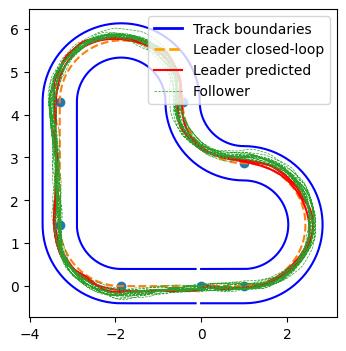

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Leader LMPC plot
plotClosedLoopLMPC(lmpc, map, last_laps_to_plot=5)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# --- Follower (1 lap) ---
traj_fc = np.array(xcl_follower)  # [vx, vy, wz, epsi, s, ey]
s = traj_fc[:, 4]
ey = traj_fc[:, 5]

L = map.TrackLength
wrap_idx = len(s)
for k in range(1, len(s)):
    if (s[k] - s[k-1]) < -0.5 * L:
        wrap_idx = k
        break

XY_1lap = np.array([map.getGlobalPosition(float(si), float(ei))
                    for si, ei in zip(s[:wrap_idx], ey[:wrap_idx])])

ax.plot(XY_1lap[:, 0], XY_1lap[:, 1], "--", linewidth=0.5, label="Follower")



# Proxy legend entries WITH colors
proxy_track   = Line2D([0], [0], color="blue",   linestyle="-",  linewidth=2,   label="Track boundaries")
proxy_leader  = Line2D([0], [0], color="orange",  linestyle="--",  linewidth=2,   label="Leader closed-loop")
proxy_pred    = Line2D([0], [0], color="red", linestyle="-", linewidth=1.5, label="Leader predicted")

# (Follower is already plotted with label="Follower", so it'll appear automatically)


# Build legend (include follower handle too)
handles = [proxy_track, proxy_leader, proxy_pred]
labels  = ["Track boundaries", "Leader closed-loop", "Leader predicted"]

# add follower handle/label (the one we actually plotted)
h_f, l_f = ax.get_legend_handles_labels()
handles += h_f
labels  += l_f

ax.legend(handles, labels, loc="best")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect("equal", adjustable="box")
plt.show()


In [54]:
print("Follower points:", XY_1lap.shape[0])
print("Follower XY range:",
      XY_1lap[:,0].min(), XY_1lap[:,0].max(),
      XY_1lap[:,1].min(), XY_1lap[:,1].max())


Follower points: 5001
Follower XY range: -3.6118788306114826 2.8193566581952085 -0.2762880596306577 5.981018217753821


# Analysis
1. What is the main advantage of using the convex local safe set?
2. Is the convex hull of the stored successfully trajectory inside the lane boundaries? Recall that the convex hull is computed in the curvilinear reference frame.
3. Why can we successfully use a learned LTV model to control a highly non-linear such a the dynamic bicycle model with additive uncertainty?

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, PillowWriter

# ================= TRACK =================
P = int(np.floor(10 * map.TrackLength))
center = np.array([map.getGlobalPosition(i*0.1, 0.0) for i in range(P)])
left   = np.array([map.getGlobalPosition(i*0.1,  map.halfWidth) for i in range(P)])
right  = np.array([map.getGlobalPosition(i*0.1, -map.halfWidth) for i in range(P)])

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(center[:,0], center[:,1], '--', color='orange', linewidth=1.5, label="Centerline")
ax.plot(left[:,0],   left[:,1],   color='blue', linewidth=2, label="Track boundary")
ax.plot(right[:,0],  right[:,1],  color='blue', linewidth=2)

ax.set_aspect('equal')
ax.set_xlim(center[:,0].min()-1, center[:,0].max()+1)
ax.set_ylim(center[:,1].min()-1, center[:,1].max()+1)

# ================= HELPERS =================
Ltrack = map.TrackLength

def first_lap_xy_s_from_curv(traj_curv):
    """Return (XY, s) for first lap (until s wraps). traj_curv: [vx, vy, wz, epsi, s, ey]."""
    traj_curv = np.array(traj_curv)
    s  = traj_curv[:, 4]
    ey = traj_curv[:, 5]

    wrap_idx = len(s)
    for k in range(1, len(s)):
        if (s[k] - s[k-1]) < -0.5 * Ltrack:
            wrap_idx = k
            break

    s_1 = s[:wrap_idx]
    ey_1 = ey[:wrap_idx]

    XY = np.array([map.getGlobalPosition(float(si), float(ei))
                   for si, ei in zip(s_1, ey_1)])
    return XY, s_1

def heading_from_xy(XY):
    d = np.diff(XY, axis=0)
    psi = np.zeros(len(XY))
    if len(XY) > 1:
        psi[1:] = np.arctan2(d[:,1], d[:,0])
        psi[0] = psi[1]
    return psi

CAR_L = 0.40
CAR_W = 0.20

def car_shape(x, y, psi):
    dx, dy = CAR_L/2, CAR_W/2
    R = np.array([[np.cos(psi), -np.sin(psi)],
                  [np.sin(psi),  np.cos(psi)]])
    pts = np.array([[ dx,  dy],
                    [ dx, -dy],
                    [-dx, -dy],
                    [-dx,  dy]])
    return pts @ R.T + np.array([x, y])

# ================= DATA =================
# Leader from PID lap
XY_L, sL_1 = first_lap_xy_s_from_curv(xcl_pid)
psi_L = heading_from_xy(XY_L)

# Follower from follower trajectory
XY_F, sF_1 = first_lap_xy_s_from_curv(xcl_follower)
psi_F = heading_from_xy(XY_F)

# sync lengths
T = min(len(XY_L), len(XY_F), len(sL_1), len(sF_1))
XY_L, XY_F = XY_L[:T], XY_F[:T]
psi_L, psi_F = psi_L[:T], psi_F[:T]
sL_1, sF_1 = sL_1[:T], sF_1[:T]

# ================= PLOTS TO ANIMATE =================
trail = 80

leader_traj, = ax.plot([], [], 'k-', lw=2, label="Leader (trail)")
foll_traj,   = ax.plot([], [], 'g--', lw=2, alpha=0.9, label="Follower (trail)")

carL = patches.Polygon(np.zeros((4,2)), closed=True, fc='black', ec='black', alpha=0.8)
carF = patches.Polygon(np.zeros((4,2)), closed=True, fc='green', ec='black', alpha=0.8)
ax.add_patch(carL)
ax.add_patch(carF)

# OPTIONAL: line showing distance between cars (visual)
gap_line, = ax.plot([], [], color="gray", linewidth=1.5, alpha=0.8, label="Gap line")

title = ax.text(0.5, 1.02, "", transform=ax.transAxes, ha="center")
gap_text = ax.text(0.02, 0.98, "", transform=ax.transAxes, ha="left", va="top",
                   bbox=dict(facecolor="white", alpha=0.75, edgecolor="none"))

ax.legend(loc="lower left")

# ================= FRAMES =================
STEP = 3
frames = list(range(0, T, STEP))

def update(i):
    i0 = max(0, i - trail)

    # leader
    leader_traj.set_data(XY_L[i0:i+1, 0], XY_L[i0:i+1, 1])
    carL.set_xy(car_shape(XY_L[i,0], XY_L[i,1], psi_L[i]))

    # follower
    foll_traj.set_data(XY_F[i0:i+1, 0], XY_F[i0:i+1, 1])
    carF.set_xy(car_shape(XY_F[i,0], XY_F[i,1], psi_F[i]))

    # gap in curvilinear coordinates (forward distance along track)
    gap = float((sL_1[i] - sF_1[i]) % Ltrack)
    gap_text.set_text(f"Gap Δs = {gap:.2f} m\nDesired = {map.DesiredGap:.2f} m")

    # optional visual line between cars
    gap_line.set_data([XY_F[i,0], XY_L[i,0]], [XY_F[i,1], XY_L[i,1]])

    title.set_text(f"Leader + Follower (k={i})")
    return leader_traj, foll_traj, carL, carF, gap_line, title, gap_text

ani = FuncAnimation(fig, update, frames=frames, interval=60, blit=True)

ani.save("leader_follower.gif", writer=PillowWriter(fps=15))
plt.close(fig)
print("Saved: leader_follower.gif")


Saved: leader_follower.gif


In [51]:
import os, webbrowser
webbrowser.open("leader_follower.gif")


True